In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.solvers import qp

from utils.misc import *


%matplotlib inline

In [2]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logcal constriant


t = 3 # number of tasks 
v = 2 # number of logical constraints considered (cardinality of KB)
ns = 0 # number of pointwise constraints to be counted later


l = [] # L_j の要素数のリスト
s = [] # S_j の要素数のリスト
S = [] # data for consistency constraints

for i in range(t):
    if v != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    l.append(len(L[i]))
    ns += len(L[i])
    s.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks


lb = np.zeros((3 * t + ns + v, 1)) # lower bounds for variables to be optimized
ub = np.zeros((3 * t + ns + v, 1)) # upper bounds for variables to be optimized

for i in range(3 * t):
    lb[i, 0] = -100000
    ub[i, 0] = 100000

for i in range(3 * t, 3 * t + ns + v):
    lb[i, 0] = 0
    ub[i, 0] = 100000



# 目的関数の定義
# 1/2 x.T @ P @ x + q.T @ x
# の P と q を定義
# x = [w_{j1}, w_{j2}, b_j, ξ_{jl}, ξ_h] 
# len(x) = 23

H = np.zeros((3 * t + ns + v, 3 * t + ns + v))

for i in range(3 * t):
    # if (i + 1) % 3 != 0:
    H[i, i] = 1


f = np.zeros((3 * t + ns + v, 1))

for i in range(3 * t + ns):
    f[i, 0] = c1

for i in range(3 * t + ns, 3 * t + ns + v, 1):
    f[i, 0] = c2




# 制約の定義
# A @ x <= b

# A の行数，つまり制約不等式の本数
A_shape_0 = 0
for i in range(t):
    A_shape_0 += l[i]

for i in range(t):
    A_shape_0 += 2 * s[i]

for i in range(v):
    A_shape_0 += u


A = np.zeros((A_shape_0, 3 * t + ns + v))
b = np.zeros((A_shape_0, 1))
count = 0 # 制約条件の行数カウンタ


# pointwise constraints
for i in range(t):
    k = 3 * i
    for j in range(l[i]):
        A[j + count, k] = -2 * L[i][j, 0] * L[i][j, 2]
        A[j + count, k + 1] = -2 * L[i][j, 1] * L[i][j, 2]
        A[j + count, k + 2] = -2 * L[i][j, 2]
        A[j + count, count + j + 3 * t] = -2
        b[j + count, 0] = -1 - L[i][j, 2]
    count += l[i]


# consistency constraints
if v > 0:
    for i in range(t):
        k = 3 * i
        for j in range(s[i]):
            A[j + count, k] = S[i, j, 0]
            A[j + count, k + 1] = S[i, j, 1]
            A[j + count, k + 2] = 1
            b[j + count, 0] = 1
            A[j + count + s[i], k] = - S[i, j, 0]
            A[j + count + s[i], k + 1] = - S[i, j, 1]
            A[j + count + s[i], k + 2] = - 1
            b[j + count + s[i], 0] = 0

        #     print(f'j + count: {j + count}')
        #     print(f'j + count + s[i]: {j + count + s[i]}')
        # print()

        count += 2 * s[i]


# logical constraints
if v > 0:
    for i in range(v):
        k = 3 * i
        for j in range(u):
            A[j + count, k] = U[j, 0]
            A[j + count, k + 1] = U[j, 1]
            A[j + count, k + 2] = 1
            A[j + count, k + 3] = -U[j, 0]
            A[j + count, k + 4] = -U[j, 1]
            A[j + count, k + 5] = -1
            A[j + count, 3 * t + ns + i] = -1
            b[j + count, 0] = 0

            # print(f'k: {k, k+1, k+2, k+3, k+4, k+5}')
            # print(f'3*t+ns+i: {3*t+ns+i}')
            # print()

        count += u






P = matrix(H)
q = matrix(f)
G = matrix(A)
h = matrix(b)

sol = qp(P=P, q=q, G=G, h=h)

print(sol)

     pcost       dcost       gap    pres   dres
 0: -5.1712e+00  1.5563e+01  3e+02  3e+00  2e+00
 1:  2.7940e+01 -8.3546e+00  4e+01  4e-16  1e-15
 2:  1.6627e+01  1.1384e+01  5e+00  2e-16  9e-16
 3:  1.4835e+01  1.3355e+01  1e+00  2e-16  2e-15
 4:  1.4278e+01  1.4034e+01  2e-01  1e-16  7e-15
 5:  1.4165e+01  1.4146e+01  2e-02  1e-16  4e-14
 6:  1.4153e+01  1.4152e+01  8e-04  1e-16  1e-13
 7:  1.4152e+01  1.4152e+01  8e-06  2e-16  2e-13
Optimal solution found.
{'x': <23x1 matrix, tc='d'>, 'y': <0x1 matrix, tc='d'>, 's': <84x1 matrix, tc='d'>, 'z': <84x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 8.218234993420737e-06, 'relative gap': 5.807151456137642e-07, 'primal objective': 14.151929440704219, 'dual objective': 14.151921222469227, 'primal infeasibility': 1.7121861111749252e-16, 'dual infeasibility': 1.7418815354244914e-13, 'primal slack': 1.3075567466075398e-08, 'dual slack': 3.7358132879776705e-08, 'iterations': 7}


In [6]:
list(sol['x'])

[4.826574658878983e-06,
 1.2904594828882914e-05,
 -6.911760591301613e-06,
 8.282529615895249e-07,
 1.5178576306274154e-05,
 -3.7630843165390893e-06,
 -0.9692292784259395,
 0.3230935751552751,
 0.8076876682102567,
 4.133549083368709e-08,
 1.988484056089282e-07,
 0.9999951582535324,
 0.9999935527682199,
 8.914550733078963e-07,
 2.8234391847299956e-06,
 0.999991472713881,
 0.9999940943026614,
 0.48461469001213775,
 0.032309408314695566,
 0.19230206052296786,
 0.4507614865352223,
 1.5360212401475804e-08,
 9.86127436891358e-09]

In [10]:
list(sol['x'])[:3]

coeff_0 = list(sol['x'])[:3]
coeff_1 = list(sol['x'])[3:6]
coeff_2 = list(sol['x'])[6:9]

coeff_0, coeff_1, coeff_2

([4.826574658878983e-06, 1.2904594828882914e-05, -6.911760591301613e-06],
 [8.282529615895249e-07, 1.5178576306274154e-05, -3.7630843165390893e-06],
 [-0.9692292784259395, 0.3230935751552751, 0.8076876682102567])

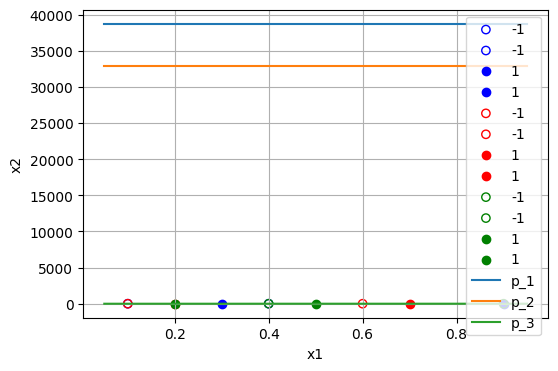

In [12]:
def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(3):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)

len_l = 4
len_u = 6
len_s = 10

len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100


w_j = cp.Variable(shape=(len_j, 3))
xi_j_l = cp.Variable(shape=(len_j, len_l), nonneg=True)
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)



# 目的関数
function = 0

for j in range(len_j):
    w = w_j[j]
    function += 1/2 * (cp.norm2(w) ** 2)

for j in range(len_j):
    for l in range(len_l):
        xi = xi_j_l[j, l]
        function += c1 * xi

for h in range(len_h):
    xi = xi_h[h, 0]
    function += c2 * xi

objective_function = cp.Minimize(function)



# 制約
constraints = []

class Predicate:
    def __init__(self, w):
        self.w1 = w[0]
        self.w2 = w[1]
        self.b = w[2]

    def func(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b

# def predicate(x, w):
#     x1, x2 = x[0], x[1]
#     w1, w2, b = w[0], w[1], w[2]

#     return w1 * x1 + w2 * x2 + b


# pointwise
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func 
    # p = predicate

    for l in range(len_l):
        x = L[j][l, :2]
        y = L[j][l, 2]

        xi = xi_j_l[j, l]

        constraints += [
            y * (2 * p(x) - 1) >= 1 - 2 * xi
            # y * (2 * p(x, w) - 1) >= 1 - 2 * xi
        ]


# logical
for h in range(len_h):
    w_1 = w_j[h]
    w_2 = w_j[h + 1]

    p_j = Predicate(w_1).func
    p_k = Predicate(w_2).func
    # p = predicate

    xi = xi_h[h, 0]

    for u in range(len_u):
        x = U[u]

        constraints += [
            p_j(x) - p_k(x) <= xi,
            # p(x, w_1) - p(x, w_2) <= xi,
        ]


# consistency
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func
    # p = predicate

    for s in range(len_s):
        x = S[j][s]

        constraints += [
            p(x) >= 0,
            p(x) <= 1,
            # p(x, w) >= 0,
            # p(x, w) <= 1,
        ]


problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 03 04:28:24 PM: Your problem has 23 variables, 84 constraints, and 0 parameters.
(CVXPY) Oct 03 04:28:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 03 04:28:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 03 04:28:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 03 04:28:24 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 03 04:28:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

(CVXPY) Oct 03 04:28:24 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 03 04:28:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 03 04:28:24 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 03 04:28:24 PM: Applying reduction ECOS
(CVXPY) Oct 03 04:28:24 PM: Finished problem compilation (took 1.875e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 03 04:28:24 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.866e+02  -2.376e+02  +4e+03  5e-01  4e-01  1e+00  4e+01    ---    ---    1  1  - |  -  - 
 1  +1.088e+02  -6.993e+01  +2e+03  2e-01  1e-01  3e+00  2e+01  0.6245  1e-01   2  1  

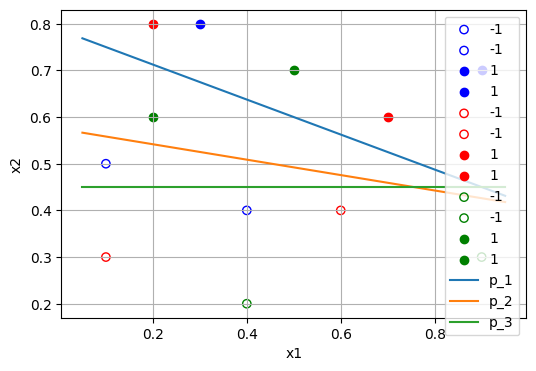

In [33]:
coeff_0 = w_j.value[0]
coeff_1 = w_j.value[1]
coeff_2 = w_j.value[2]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()